In [2]:

import psycopg2 as pg2
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, confusion_matrix, precision_score, recall_score, accuracy_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np
import pickle
from datetime import datetime, date, timedelta
import importlib

In [3]:
def get_list_of_dates():

    sdate = date(2020, 2, 23)   # start date
    edate = date(2020, 2, 28)   # end date

    delta = edate - sdate       # as timedelta

    return [pd.Timestamp(sdate + timedelta(days=i)) for i in range(delta.days + 1)]
        
get_list_of_dates()

[Timestamp('2020-02-23 00:00:00'),
 Timestamp('2020-02-24 00:00:00'),
 Timestamp('2020-02-25 00:00:00'),
 Timestamp('2020-02-26 00:00:00'),
 Timestamp('2020-02-27 00:00:00'),
 Timestamp('2020-02-28 00:00:00')]

In [294]:
def print_profit_threshold (y_test, probs, X_test):
    for thresh in np.arange(.4, 1.1, .05): # threshes:
        y_pred = probs >= thresh
        cm = confusion_matrix(y_test, y_pred)
        print("*****************************")
        print("thresh:", thresh)
        acc = accuracy_score(y_test, y_pred) * 100
        prec = precision_score(y_test, y_pred) *100
        rec = recall_score(y_test, y_pred) *100
        print (f"Accuracy: {acc:.2f} Precision: {prec:.2f}  Recall:{rec:.2f} ")
        print(cm)
        true_positive_mask = (y_pred==True)&(y_test==True)
        print(true_positive_mask.shape, X_test.shape)
        profit = sum(X_test.cashvalue[true_positive_mask])-sum(y_pred)*.40 - sum(X_test.fee[true_positive_mask]) - sum(X_test.bid[true_positive_mask])/100
        profit_per_bid = profit/sum(y_pred)
        print(f"profit: {profit:.2f}")
        print(f"profit per bid: {profit_per_bid:.2f}")
        winners = X_test[true_positive_mask].groupby("cashvalue").count()
        print(winners.is_winner)
        print("*****************************")
        print("")

In [282]:
print ("Connecting to SQL")
conn = pg2.connect(user='postgres',  dbname='penny', host='localhost', port='5432', password='password')

print ("Reading Dataset")
df = pd.read_sql ("""Select *  from auction_full where auctiontime >= '2020-01-05'""", conn)

print ("Splitting into Train/Test Sets")
df = df.sort_values("auctiontime")
y = df['is_winner']


Connecting to SQL
Reading Dataset


KeyboardInterrupt: 

In [283]:
X = df

df['profit'] = df['is_winner'] * (df["cashvalue"] - df["fee"] - df["bid"]/100) -.4
y=df['profit']


In [284]:
y = df['is_winner']

In [354]:
import importlib
import BuildModel
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
importlib.reload(BuildModel)

date_list = get_list_of_dates()


#for i in range(1, len(date_list)):
train_cut_off  = datetime(2020, 1, 20) #date_list[i-1]
test_cut_off = datetime(2020, 2, 10) #date_list[i]
print (train_cut_off, test_cut_off)
X_train = X[X.auctiontime <= train_cut_off]
y_train = y[X.auctiontime <= train_cut_off]

#win_mask = X_train.is_winner == True
#lose_mask = X_train.is_winner == False
#X_train = pd.concat([X_train[lose_mask].sample(frac=.1), X_train[win_mask]], axis=0)
#y_train = pd.concat([y_train[lose_mask].sample(frac=.1), y_train[win_mask]], axis=0)


X_test = X[(X.auctiontime > train_cut_off)&(X.auctiontime <= test_cut_off)]
y_test = y[(X.auctiontime > train_cut_off)&(X.auctiontime <= test_cut_off)]

2020-01-20 00:00:00 2020-02-10 00:00:00


In [255]:

    #X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)#, random_state=0) 

In [355]:
    
#def create_model():
#    # Define a Keras model
#    model = Sequential()
#
#    # Add a Dense layer that uses the sigmoid function
#    model.add(Dense(units=30, init = 'uniform', activation='relu', input_dim=74))
#    model.add(Dense(units=30, init = 'uniform', activation='relu'))
#    model.add(Dense(units=1, activation='sigmoid'))
#    
#    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#    return model

#clf = KerasClassifier(build_fn=create_model,epochs=8,batch_size=10) #, validation_split=.1)

    
print ("Fitting Model")
#pm = BuildModel.PennyModel(RandomForestRegressor(n_estimators=200, n_jobs=-1), is_regressor=True )
pm = BuildModel.PennyModel(RandomForestClassifier(n_estimators=200, n_jobs=-1), is_regressor=False )

pm.fit(X_train, y_train)

Fitting Model
2. Transforming data
4. Fitting model


In [356]:
y_pred = pm.predict(X_test)

2. Transforming data


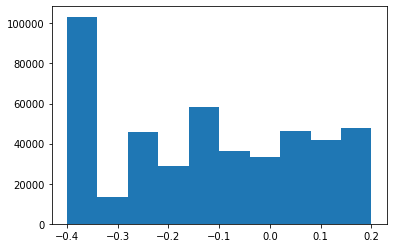

In [274]:
fig, ax = plt.subplots()
#mask = y_pred
#print(sum(mask))
ax.hist(y_pred[y_pred < 0.2])
fig.show()

In [275]:
y_test[y_pred < .4]

367296    -0.4
367298    -0.4
367300    -0.4
367294    -0.4
367311    -0.4
          ... 
3754448   -0.4
3754450   -0.4
3754452   -0.4
3754439   -0.4
3730331   -0.4
Name: profit, Length: 596240, dtype: float64

In [277]:
for i in range(100):
    print(i,sum(y_test[y_pred>i]))

0 -659777.9400388424
1 -434945.60001667787
2 -269911.1099940577
3 -160132.06999606066
4 -85663.829999438
5 -38393.59000045569
6 -10187.909999926294
7 9309.510000151817
8 16937.41999998672
9 22073.249999911204
10 24848.939999890652
11 22711.53999993983
12 19598.65999999625
13 17535.690000010298
14 16159.06000002964
15 13097.65000002269
16 10987.080000018155
17 9290.980000014297
18 8156.870000010895
19 5976.760000001829
20 4147.499999997508
21 2643.9899999980726
22 2030.239999998791
23 1581.5299999990716
24 281.0800000002036
25 -161.79999999961257
26 -838.3800000006388
27 -1130.2100000007958
28 -1861.910000000724
29 -2186.560000000714
30 -2479.83000000073
31 -2663.270000000759
32 -2739.050000000735
33 -2626.0500000006864
34 -2551.280000000663
35 -2563.330000000659
36 -2615.210000000658
37 -2514.3400000006386
38 -2425.840000000578
39 -2578.910000000563
40 -2703.240000000532
41 -2658.8800000005012
42 -2632.400000000502
43 -2387.200000000446
44 -2266.340000000425
45 -2288.770000000414
46 -2

In [281]:
y = df['is_winner']
y_train = y[X.auctiontime <= train_cut_off]
y_train = pd.concat([y_train[lose_mask].sample(frac=.1), y_train[win_mask]], axis=0)
y_test = y[(X.auctiontime > train_cut_off)&(X.auctiontime <= test_cut_off)]

pm = BuildModel.PennyModel(RandomForestClassifier(n_estimators=200, n_jobs=-1), is_regressor=False )
pm.fit(X_train, y_train)

2. Transforming data
4. Fitting model


In [357]:
print ("Calculating predictions")
probs = pm.predict_proba(X_test)[:,1]
threshes = np.unique(probs)
threshes = threshes[threshes > .4]

print_profit_threshold(y_test, probs, X_test)

Calculating predictions
2. Transforming data
*****************************
thresh: 0.4
Accuracy: 56.40 Precision: 1.04  Recall:87.09 
[[886140 689480]
 [  1074   7243]]
(1583937,) (1583937, 83)
profit: -63054.39
profit per bid: -0.09
cashvalue
6       912
10     1234
15       48
20      865
21       67
23       67
25       44
27       83
29       23
30       21
31        4
33      893
35       12
36       41
37     1010
38       35
40      359
42       54
58       90
62      620
64      478
79        3
81        2
83        2
85        1
87       35
100     211
108       3
112      13
162      13
Name: is_winner, dtype: int64
*****************************

*****************************
thresh: 0.45


KeyboardInterrupt: 

In [279]:
X_test.profit

367325    -0.40
367343    -0.40
367295    -0.40
367296    -0.40
367297    -0.40
           ... 
3730343   -0.40
3730345   -0.40
3730346    9.44
3730334   -0.40
3730344   -0.40
Name: profit, Length: 3423375, dtype: float64

In [361]:
print(sum(X_train.is_winner), X_train.shape[0])

5533 1086074


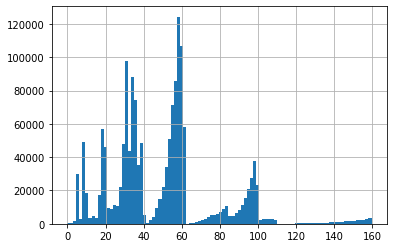

In [379]:
PotentialProfit = (X_test.cashvalue - X_test.fee - X_test.bid/100) -.4
PotentialProfit.hist(bins=100)
X_test.profit
probs
pp_df = pd.concat([PotentialProfit, pd.Series(probs), X_test.profit], axis=1)
#sum(X_test.profit[Expected_Values > 10])

In [393]:
X_test["PotentialProfit"] =  (X_test.cashvalue - X_test.fee - X_test.bid/100) -.4
X_test["prob"] = probs


/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [427]:
import math
def get_profit(l, u):
    maxprof = -math.inf
    maxp = 0
    for p in np.arange(0, 1, .01):
        profit = sum(X_test["profit"][(X_test.prob > p)&(X_test.PotentialProfit > l)&(X_test.PotentialProfit < u)])
        if (profit > maxprof):
            maxp = p
            maxprof = profit
    return maxp, maxprof

In [433]:
print(get_profit(0, 5.7))
print(get_profit(5.7, 9.7))
print(get_profit(9.7,19.7))
print(get_profit(19.7,40))
print(get_profit(40, 62))
print(get_profit(62, 100))
print(get_profit(100, 200))

(0.93, 17.660000000000245)
(0.86, 223.01999999998824)
(0.76, 1260.37000000002)
(0.66, 19881.459999999595)
(0.55, 21797.02999999191)
(0.52, 6933.250000001273)
(0.55, 1126.3800000000188)


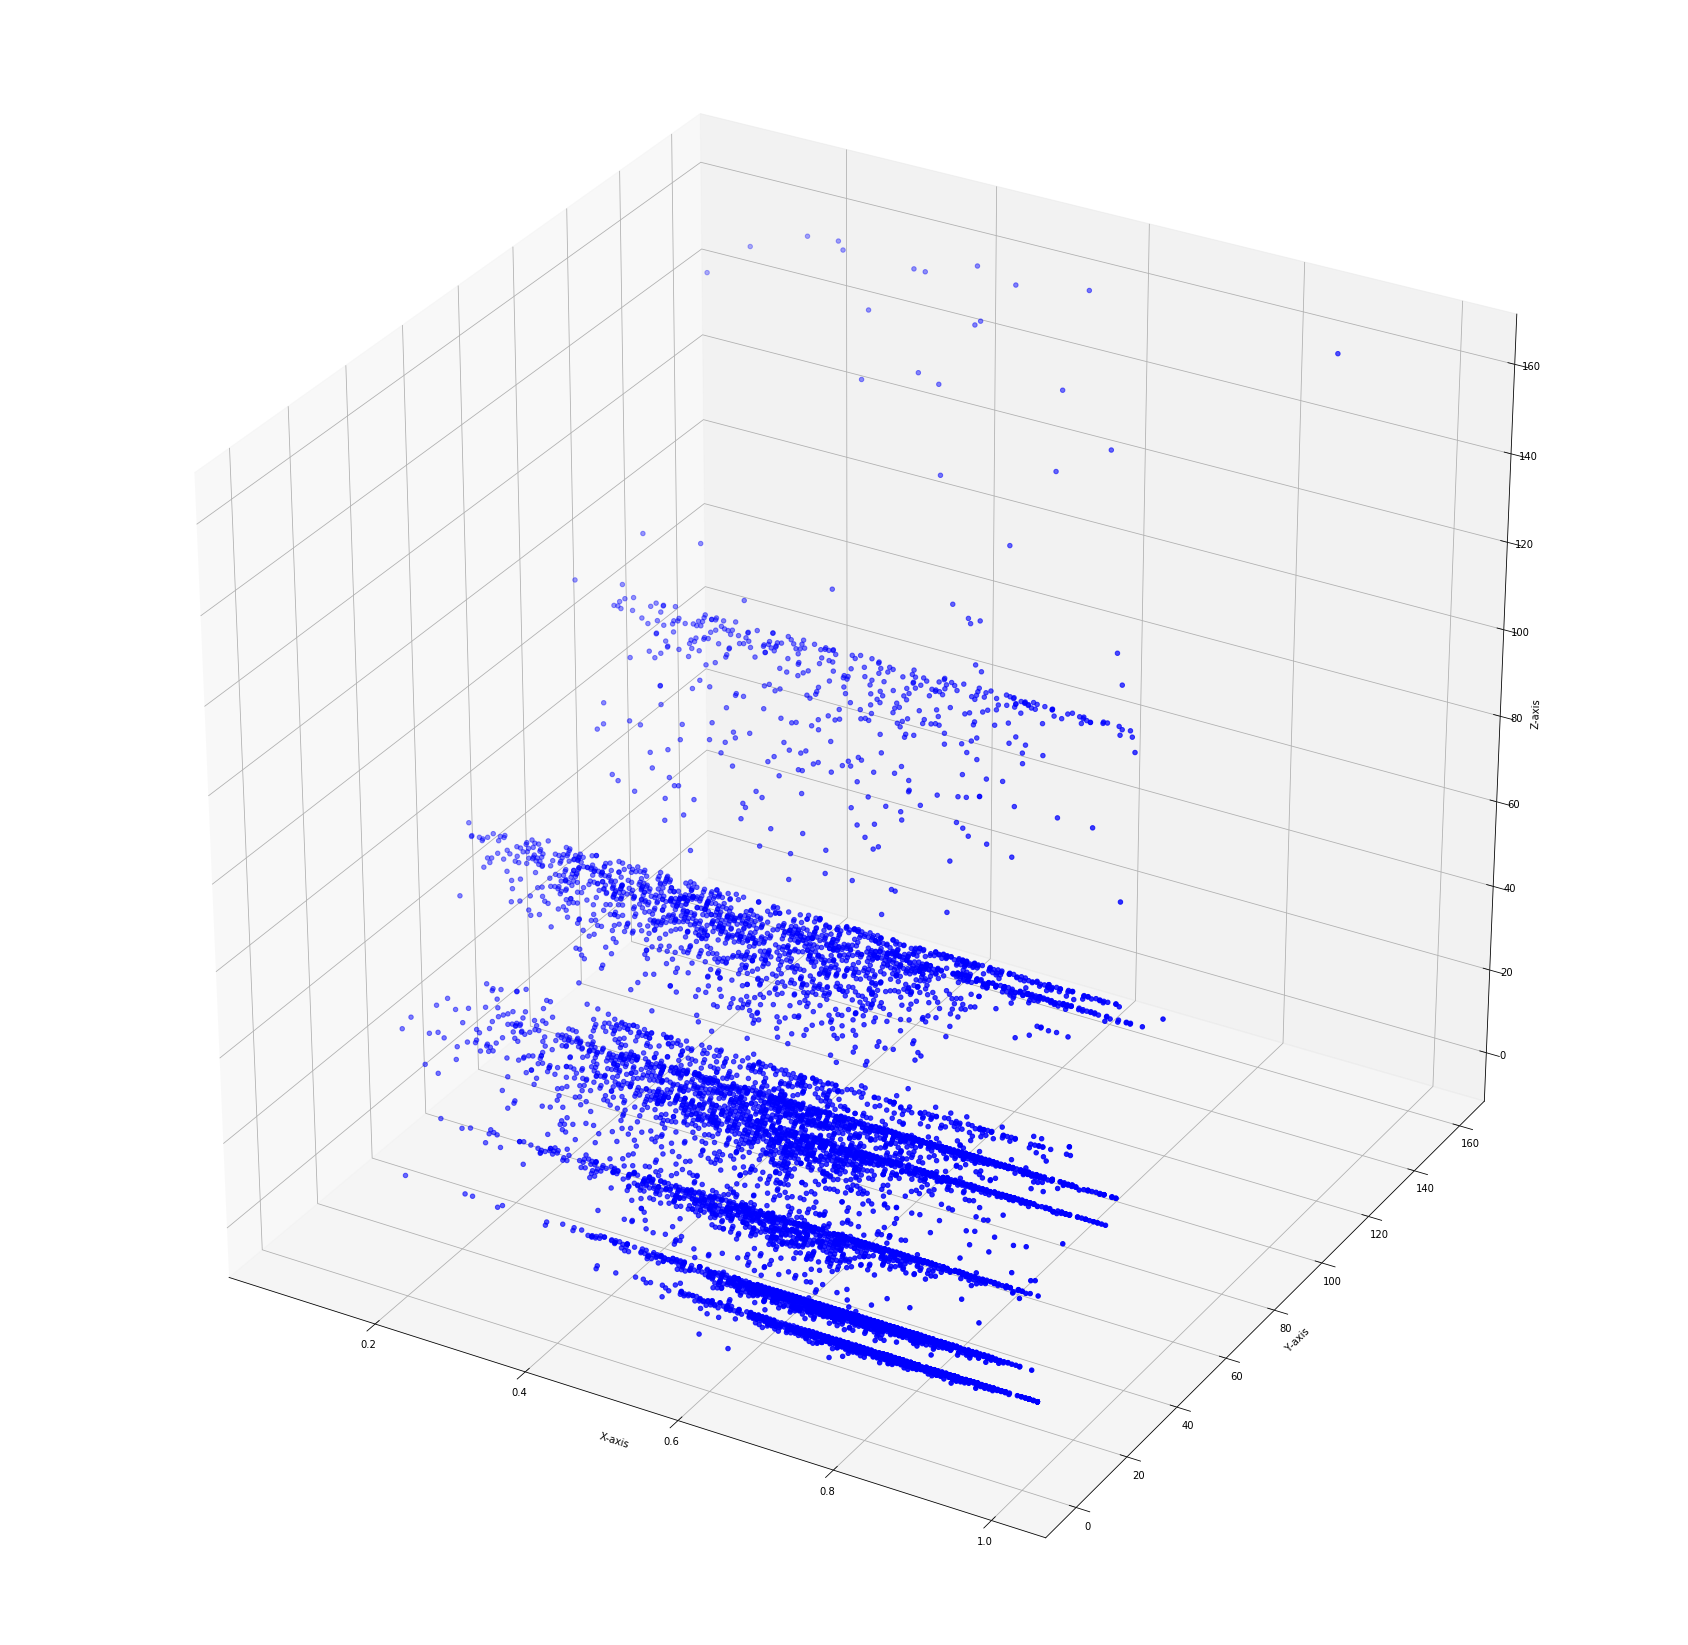

In [402]:
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
import random

fig = plt.figure(figsize=(30,30))
ax = fig.add_subplot(111, projection='3d')

# Generate the values
x_vals = X_test["prob"][X_test.is_winner]
y_vals = X_test["PotentialProfit"][X_test.is_winner]
z_vals = X_test["profit"][X_test.is_winner]

# Plot the values
ax.scatter(x_vals, y_vals, z_vals, c = 'b', marker='o')
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')

plt.show()

In [142]:

print ("Plotting features")
# Plot the feature importance
feat_scores = pm.get_feature_scores()
feat_scores = feat_scores.sort_values()
fig, ax = plt.subplots()
ax = feat_scores.plot(kind='barh', 
                      figsize=(10,8),
                      color='b')
ax.set_title('Average Gini Importance')
ax.set_xlabel('Average contribution to information gain')



Plotting features


IndexError: list index out of range

In [106]:
sum(y_pred < 0)

1143137

In [105]:
sum(y_test[y_pred>50])

-2105.0600000003597

In [77]:
sum(X_train.profit==-.4)

3338599

In [76]:
sum(X_train.profit > -.4)

17799

In [56]:
sum(lose_mask) * .01

33385.99